In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. 
The dataset contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

## Goal
The goal is to build a predictive model that is trained on the following data:

- latitude and longitude (location)
- Hour of the day
- Day of the week
- Area-of-command code: The police designation of the bureau of the operation.
- Classification code for the crime committed
- The predicted variable is the number of persons involved in the accident.



In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])


In [3]:
df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

## Task 1
- print a few rows of the values in the dataframe df and explain what each column of data means.
- identify the input and target variables
- what is the range of values in each column? Do you need to scale, shift or normalize your data?

In [7]:
# Point 1

# Print a few rows of the values in the dataframe
print("Snippet of few rows in the dataframe:")
print(df.head(10))

# Explain what each column of data means
column_explanations = {
    'X': 'X coordinate of the location',
    'Y': 'Y coordinate of the location',
    'Area_Command': 'The police designation of the bureau of the operation',
    'NIBRSOffenseCode': 'National Incident-Based Reporting System offense code',
    'DayOfWeek': 'Day of the week the incident was reported',
    'Time': 'Hour of the day the incident was reported',
    'VictimCount': 'Predicted variable representing the number of people involved in the accident'
}
print("\nEach column explanations:")
for col, explanation in column_explanations.items():
    print(f"\t{col}: {explanation}")

# Point 2: Identify the input and target variables
input_variables = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
target_variable = ['VictimCount']
print("\nInput Variables:", ", ".join(input_variables))
print("Target Variable:", ", ".join(target_variable))

# Point 3
# Range of values in each column
print("\nRange of values in each column:")
for col in df.columns:
    print(f"\t{col}: {df[col].min()} to {df[col].max()}")

# Do you need to scale, shift or normalize your data?
print("\nData Scaling/Normalization:")
print("\u2022 Given the range of values, especially for coordinates, it might be beneficial to scale or normalize the data, especially if you are using machine learning algorithms sensitive to the scale of input features.")
print("\u2022 Feature scaling becomes necessary when dealing with datasets containing features that have different ranges, units of measurement, or orders of magnitude. In such cases, the variation in feature values can lead to biased model performance or difficulties during the learning process.")
print("\u2022 Reference: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/")

Snippet of few rows in the dataframe:
            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   
5 -115.132162  36.100841             5                 1          3     4   
6 -115.176012  36.194067             1                 1          4     5   
7 -115.194061  36.135213             3                 1          4     3   
8 -115.069716  36.191304             0                 1          5     6   
9 -115.309341  36.074367             6                 1          6     1   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  
5           

## Task 2
- Create two DataLoader objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(df[input_variables].values, dtype=torch.float32)
y = torch.tensor(df[target_variable].values, dtype=torch.float32)

# Split the data into training and testing sets in 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data
for X_batch, y_batch in train_loader:
    print("Shape of X batch:", X_batch.shape)
    print("Shape of y batch:", y_batch.shape)
    break

print("\nReferences:")
print("\u2022 https://pytorch.org/docs/stable/data.html")
print("\u2022 https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset")


Shape of X batch: torch.Size([32, 6])
Shape of y batch: torch.Size([32, 1])

References:
• https://pytorch.org/docs/stable/data.html
• https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset


## Task 3

In this task you will try to predict number of crime victims as a real number. Therefore the machine learning problem is a regression problem.

- Define the proper loss function for this task
- what should the size of the predicted output be?
- explain your choice of architecture, including how many layers you will be using
- define an optimizer for training this model, choose a proper learning rate
- write a training loop that obtains a batch out of the training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
- write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the MSE error on the test data and print it.
is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [25]:
import torch.nn as nn


criterion = nn.MSELoss()
print("Point 1 \n\u2022 Loss function : Have used here Mean Squared Error Loss since it is a common choice for regression problems")
print("\u2022 Reference: https://medium.com/@mlblogging.k/14-loss-functions-you-can-use-for-regression-b24db8dff987")

print("\nPoint 2 \n\u2022 Output Size: The size of the predicted output should be 1 since we are predicting a single continuous value i.e. the number of crime victims")

hidden_size = 30
print(f"\nPoint 3 \n\u2022 Choice of Architecture: A simple feedforward neural network with one hidden layer of size {hidden_size}, since a feedforward neural network aids software developers with pattern recognition and classification, non-linear regression, and function approximation")
print(f"\u2022 Batch Size: Kept batch size to {batch_size} since the loss with higher or lower values resulted in higher loss values")
print("References")
print("\u2022 https://www.kdnuggets.com/2019/11/designing-neural-networks.html")
print("\u2022 https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer.")
print("\u2022 https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/")

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


input_size = X_train.shape[1]
output_size = y_train.shape[1]
learning_rate = 0.0001

model = RegressionModel(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("\nPoint 4 \n\u2022 Optimiser: Adam optimiser is used here since a learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds")
print("\u2022 https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/")

num_epochs = 150

print("\nMSE Error on the test data:")
for epoch in range(num_epochs):
    # Training
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward passes over the neural network and the optimizer to update the weights of the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Testing
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_loss = criterion(test_predictions, y_test)
        print('Epoch [{}/{}] | Test Loss: {:.4f}'
              .format(epoch+1, num_epochs, test_loss.item()))

print("\nAs the MSE loss on the test data is continously reducing with each epoch, we can conclude that the set parameters work on the model work for this case")

Point 1 
• Loss function : Have used here Mean Squared Error Loss since it is a common choice for regression problems
• Reference: https://medium.com/@mlblogging.k/14-loss-functions-you-can-use-for-regression-b24db8dff987

Point 2 
• Output Size: The size of the predicted output should be 1 since we are predicting a single continuous value i.e. the number of crime victims

Point 3 
• Choice of Architecture: A simple feedforward neural network with one hidden layer of size 30, since a feedforward neural network aids software developers with pattern recognition and classification, non-linear regression, and function approximation
• Batch Size: Kept batch size to 32 since the loss with higher or lower values resulted in higher loss values
References
• https://www.kdnuggets.com/2019/11/designing-neural-networks.html
• https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer.
• https://www.analyti

## Task 4

In this task, you will try to predict the number of crime victims as a class number. Therefore the machine learning problem is a classification problem.

- Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
- How would you find the number of classes on the output data?
- How is the architecture different?
- How is the loss function different?
- Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
- Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [76]:
num_classes = len(df['VictimCount'].unique())
print("\nNumber of Classes:", num_classes)
print("Point 2 \nNumber of output Classes Required: We find out how many unique values there are in the target variable, so we know how many output neurons to use.")

print("\nPoint 3: Architecture difference between Regression and Classification model")
print("Regression Model:")
print(f"\t\u2022 It has one hidden layer with a size of {hidden_size}")
print("\t\u2022 The output layer produces a single continuous value.")
print("\t\u2022 ReLU activation is used in the hidden layer.")
print("Classification Model:")
print("\t\u2022 It has two hidden layers with sizes 15 and 8, respectively.")
print("\t\u2022 The output layer produces output_size number of values, which correspond to the number of classes.")
print("\t\u2022 ReLU activation is used in the hidden layers, and a softmax activation is applied at the output layer to produce probabilities of the input belonging to each class.")
print("\t\u2022 Dropout is applied after the activation functions in the hidden layers for regularization.")
print("References:")
print("\u2022 https://medium.com/analytics-vidhya/non-binary-image-classifying-cnn-tutorial-5-categories-df431449c7d5")
print("\u2022 https://www.baeldung.com/cs/ml-relu-dropout-layers#:~:text=4.,and%20leaves%20unmodified%20all%20others.")
print("\u2022 https://medium.com/codex/activation-functions-in-neural-network-steps-and-implementation-df2e4c858c21#:~:text=Softmax%3A%20Softmax%20activation%20is%20typically,probability%20distribution%20over%20multiple%20classes.")

print("\nPoint 4: Loss function difference between Regression and Classification model")
print("Regression Model:")
print("\t\u2022 Mean Squared Error Loss (MSELoss) is used, which is a common choice for regression problems where the goal is to minimize the average squared difference between the predicted and actual values.")
print("Classification Model:")
print("\t\u2022 Cross-Entropy Loss (CrossEntropyLoss) is used, which is suitable for classification problems where the goal is to maximize the log-probability of the correct class.")
print("References:")
print("\u2022")


import torch

class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassificationModel, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size, 15)  # First hidden layer
        self.layer_2 = torch.nn.Linear(15, 8)  # Second hidden layer
        self.layer_3 = torch.nn.Linear(8, output_size)  # Output layer
        self.relu = torch.nn.ReLU()  # ReLU activation function
        self.dropout = torch.nn.Dropout(0.5)  # Dropout layer
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation function

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

learning_rate = 0.001

model = ClassificationModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 90 

print("\nAccuracy on the test data:")
for epoch in range(num_epochs):
    # Training
    model.train()
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.long().squeeze()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Testing
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.long().squeeze())
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = (predicted == y_test.squeeze()).sum().item() / y_test.size(0)
        print('Epoch [{}/{}], Test Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, test_loss.item(), 100 * accuracy))



Number of Classes: 7
Point 2 
Number of output Classes Required: We find out how many unique values there are in the target variable, so we know how many output neurons to use.

Point 3: Architecture difference between Regression and Classification model
Regression Model:
	• It has one hidden layer with a size of 25
	• The output layer produces a single continuous value.
	• ReLU activation is used in the hidden layer.
Classification Model:
	• It has two hidden layers with sizes 15 and 8, respectively.
	• The output layer produces output_size number of values, which correspond to the number of classes.
	• ReLU activation is used in the hidden layers, and a softmax activation is applied at the output layer to produce probabilities of the input belonging to each class.
	• Dropout is applied after the activation functions in the hidden layers for regularization.
References:
• https://medium.com/analytics-vidhya/non-binary-image-classifying-cnn-tutorial-5-categories-df431449c7d5
• https://

## Task 5
Reflect on your results
- Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
- Write a piece of code that finds an example of a miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Point 1
Experience with task 3 and 4
• We tried to train our data using both classification and regression model.
• This was possible to acheive since for regression we had a continous real number as our output which works well for regression model and a finite number of discrete values which works well for classification model
• In my experience, regression worked well even with a simple feedforward NN with just one hidden layer whereas for regression I had to add layers and remove interatively in order to acheive an accuray higher than 50% (apart from adjusting other values like learning rate, hidden layer size, no. of epochs etc, which was required in both)
Comparision of results:
• In Classification the loss decreased significantly over time, indicating that the model was learning and improving its predictions.
• In Regression the loss values were higher at the beginning but decreased steadily, showing that the model was able to reduce the error in its predictions.
Better Model and

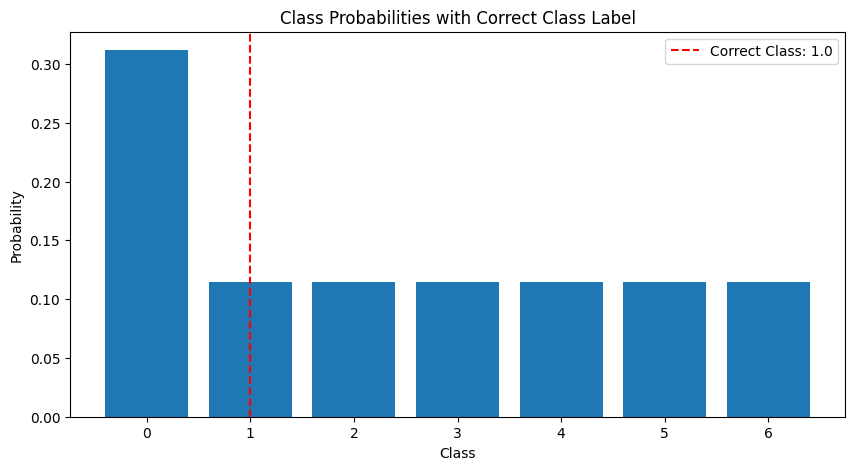

In [78]:
print("Point 1")
print("Experience with task 3 and 4")
print("\u2022 We tried to train our data using both classification and regression model.")
print("\u2022 This was possible to acheive since for regression we had a continous real number as our output which works well for regression model and a finite number of discrete values which works well for classification model")
print("\u2022 In my experience, regression worked well even with a simple feedforward NN with just one hidden layer whereas for regression I had to add layers and remove interatively in order to acheive an accuray higher than 50% (apart from adjusting other values like learning rate, hidden layer size, no. of epochs etc, which was required in both)")
print("Comparision of results:")
print("\u2022 In Classification the loss decreased significantly over time, indicating that the model was learning and improving its predictions.")
print("\u2022 In Regression the loss values were higher at the beginning but decreased steadily, showing that the model was able to reduce the error in its predictions.")
print("Better Model and Why?")
print("\u2022 The regression model seemed to converge smoothly and shows a gradual decline, while the classification model reached a plateau relatively early in the training process. But both models showed a gradual decline in loss overtime")
print("\u2022 The results indicate that the classification task is more complex, or the model that I have used is not complex enough to capture the patterns in the data for classification.")


print("\nPoint 2")
print("References:")
print("\u2022 https://www.mathworks.com/help/stats/classificationtree.predict.html")
print("\u2022 https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch")


import matplotlib.pyplot as plt
import torch.nn.functional as F

# Finding the misclassified example
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs.data, 1)
    misclassified_index = (predicted != y_test.squeeze()).nonzero(as_tuple=True)[0][0].item()

# Calculate probability
probs = F.softmax(test_outputs[misclassified_index], dim=0)
probs = probs.numpy()

# Correct class label
correct_label = y_test.squeeze()[misclassified_index].item()

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), probs)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities with Correct Class Label')
plt.axvline(x=correct_label, color='r', linestyle='--', label=f'Correct Class: {correct_label}')
plt.legend()
plt.show()


## Task 6: Exploring the patterns in raw data
- Plot the crime incidents as a scatter plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
- Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
- use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?

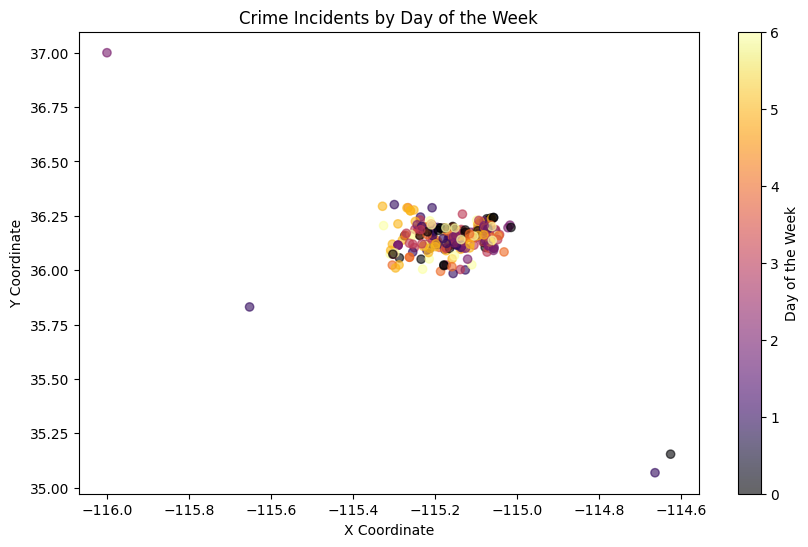


Point 1: Crime Incidents
Pattern in the graph: We can gather from the data that most of the crime incidents are centered in one big area of Las Vegas Coordinates. 
The incidents also take place more during the end of the week compared to the start of the week


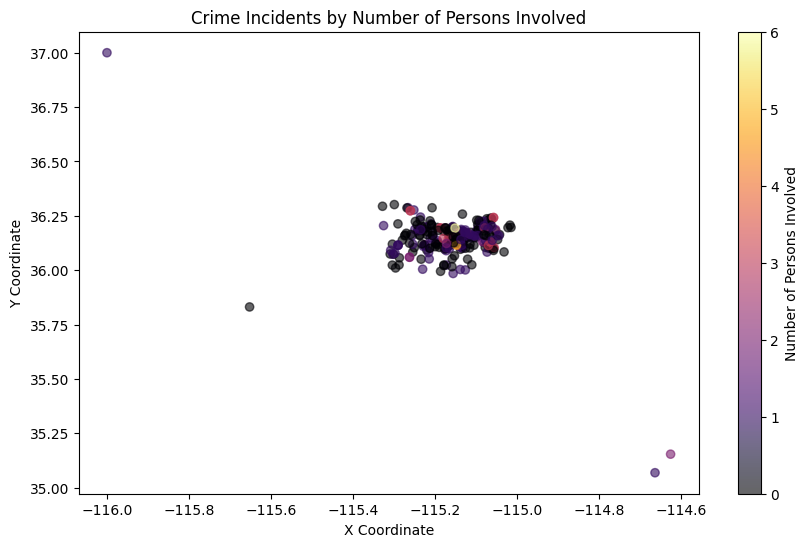


Point 2: Number of people in the incident
Pattern in the graph: We can gather from the data that most of the crime incidents are centered in one big area of Las Vegas Coordinates. 
The no. of victims involved on the spectrum is higher for the range of 0-2 compared to the rest i.e. 3-6


Monday       51
Tuesday      40
Wednesday    43
Thursday     28
Friday       44
Saturday     37
Sunday       32
Name: count, dtype: int64

In [81]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='inferno', alpha=0.6)
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Day of the Week')
plt.show()
print("\nPoint 1: Crime Incidents")
print("Pattern in the graph: We can gather from the data that most of the crime incidents are centered in one big area of Las Vegas Coordinates. \nThe incidents also take place more during the end of the week compared to the start of the week")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='inferno', alpha=0.6)
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Number of Persons Involved')
plt.show()
print("\nPoint 2: Number of people in the incident")
print("Pattern in the graph: We can gather from the data that most of the crime incidents are centered in one big area of Las Vegas Coordinates. \nThe no. of victims involved on the spectrum is higher for the range of 0-2 compared to the rest i.e. 3-6")

# 3. Crimes Reported by Day of the Week
crimes_by_day = df['DayOfWeek'].value_counts().sort_index()
day_names = orig_df['ReportedOn'].dt.day_name().unique()

# Sorting day names according to their order in a week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sorted_day_names = sorted(day_names, key=lambda x: day_order.index(x))

# Display the sorted number of crimes reported by the day of the week
crimes_by_day_sorted = crimes_by_day.sort_index(key=lambda x: x.map(dict(zip(range(7), day_order))))
crimes_by_day_sorted.index = sorted_day_names
crimes_by_day_sorted
